In [45]:
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.colors
import asilib
import asilib.map
import asilib.asi
import numpy as np
import matplotlib.gridspec
import scipy.interpolate

import IRBEM

In [19]:
location_codes = ['FSIM', 'ATHA', 'TPAS', 'SNKQ']
time = datetime(2007, 3, 13, 5, 8, 45)
map_alt = 110

In [16]:
irbem_obj = IRBEM.MagFields(kext=0)
coords_obj = IRBEM.Coords()

In [17]:
def map_eq(time, latitudes, longitudes, alt=110):
    """
    Maps geographic coordinates to magnetic equator coordinates using IRBEM.

    Parameters:
    latitudes (numpy.ndarray): 
        Array of latitudes.
    longitudes (numpy.ndarray): 
        Array of longitudes.
    alt (int): 
        Altitude in km.

    Returns:
    numpy.ndarray:
        Mapped locations in the Geocentric Solar Magnetospheric (SM) coordinates.
    """
    sm_coords = np.zeros((latitudes.shape[0], 3))

    for i, (lat, lon) in enumerate(zip(latitudes, longitudes)):
        
        # Trace the magnetic field line to the magnetic equator
        LLA = {'datetime':time, 'x1':alt, 'x2':lat, 'x3':lon}
        output_dictionary = irbem_obj.find_magequator(LLA, {})
        sm_coords[i, :] = coords_obj.transform(time, output_dictionary['XGEO'], 1, 4)  # Convert to SM coordinates
    return sm_coords

In [20]:
_imagers = [asilib.asi.themis(location_code, time=time, alt=map_alt) for location_code in location_codes]
asis = asilib.Imagers(_imagers)
lats_lons, intensities = asis.get_points()

/home/mike/research/asilib/env_212/lib/python3.12/site-packages/scipy/io/_idl.py:250: UserWarning: Not able to verify number of bytes from header
  structure[col['name']][i] = _read_structure(f,
/home/mike/research/asilib/env_212/lib/python3.12/site-packages/scipy/io/_idl.py:355: UserWarning: Not able to verify number of bytes from header
  record['data'] = _read_structure(f, rectypedesc['array_desc'],


In [21]:
lats_lons

array([[  57.23624802, -123.19360352],
       [  57.27668381, -123.25622559],
       [  57.31467819, -123.31903076],
       ...,
       [  60.5596962 ,  -81.0508728 ],
       [  60.5544014 ,  -81.12808228],
       [  60.55070496,  -81.20632935]])

In [22]:
intensities

array([2832., 2882., 2820., ..., 3794., 3821., 3815.])

In [24]:
sm_loc = map_eq(time, lats_lons[:, 0], lats_lons[:, 1], alt=map_alt)

In [52]:
x_grid, y_grid = np.meshgrid(np.linspace(-10, 0, num=1000), np.linspace(-10, 10, num=1001))

In [69]:
from scipy.interpolate.interpnd import _ndim_coords_from_arrays
from scipy.spatial import cKDTree

In [61]:
# Construct kd-tree, functionality copied from scipy.interpolate
tree = cKDTree(sm_loc[:, :2])
xi = _ndim_coords_from_arrays((x_grid, y_grid), ndim=2)
dists, indexes = tree.query(xi)

(array([159378.,  18073.,  18309.,  18766.,  19224.,  19157.,  18578.,
         18462.,  18626.,  18731.,  18858.,  18396.,  17665.,  17283.,
         16920.,  16740.,  16201.,  15377.,  14909.,  14284.,  13543.,
         13150.,  12735.,  12487.,  12144.,  11871.,  11628.,  11343.,
         11154.,  10845.,  10654.,  10398.,  10154.,  10001.,   9747.,
          9615.,   9515.,   9418.,   9361.,   9223.,   9140.,   9023.,
          8916.,   8373.,   7428.,   6890.,   6369.,   6095.,   5986.]),
 array([0.        , 0.10204082, 0.20408163, 0.30612245, 0.40816327,
        0.51020408, 0.6122449 , 0.71428571, 0.81632653, 0.91836735,
        1.02040816, 1.12244898, 1.2244898 , 1.32653061, 1.42857143,
        1.53061224, 1.63265306, 1.73469388, 1.83673469, 1.93877551,
        2.04081633, 2.14285714, 2.24489796, 2.34693878, 2.44897959,
        2.55102041, 2.65306122, 2.75510204, 2.85714286, 2.95918367,
        3.06122449, 3.16326531, 3.26530612, 3.36734694, 3.46938776,
        3.57142857, 3.673

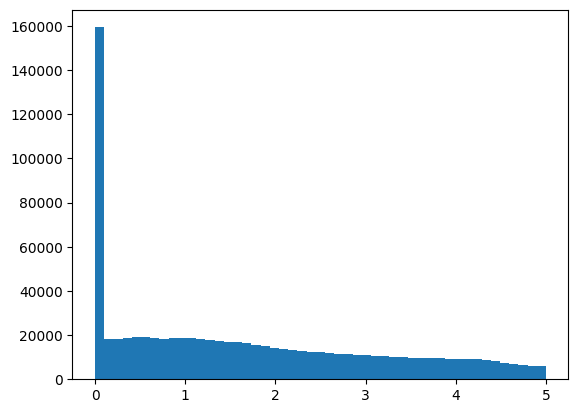

In [73]:
plt.hist(dists.flatten(), bins=np.linspace(0, 5))

In [76]:
gridded_eq_data = scipy.interpolate.griddata(sm_loc[:, :2], intensities, (x_grid, y_grid), fill_value=np.nan, method='nearest')
gridded_eq_data_copy = gridded_eq_data[:]
gridded_eq_data_copy[dists > 0.1] = np.nan  # Mask any gridded point > 0.1 Re from the mapped point as NaN

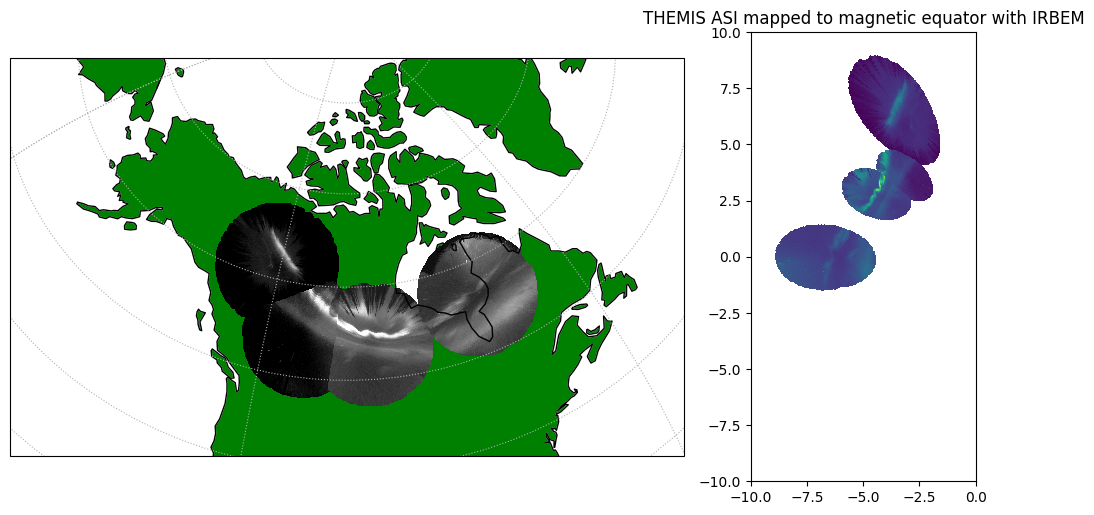

In [77]:
fig = plt.figure(figsize=(10, 6))
gs = matplotlib.gridspec.GridSpec(1, 2, fig, width_ratios=(3, 1))
ax = asilib.map.create_map(fig_ax=(fig, gs[0, 0]))
bx = fig.add_subplot(gs[0, 1])
bx.set_aspect('equal')

asis.plot_map(ax=ax, asi_label=False)
bx.pcolormesh(x_grid, y_grid, gridded_eq_data_copy, norm=matplotlib.colors.LogNorm())

plt.title('THEMIS ASI mapped to magnetic equator with IRBEM')
plt.tight_layout()
plt.show()